# SISTER workflow

In [ ]:
import json
import os
import xml.etree.ElementTree as ET
import pandas as pd
import IPython

# Import warnings module and ignore warnings in output below
import warnings
warnings.filterwarnings("ignore")

# Import and initialize MAAP class
from maap.maap import MAAP
maap = MAAP(maap_host="sister-api.imgspec.org")

def get_output(job_id):
    result = maap.getJobResult(job_id)
    granule = result.outputs[0] 
    quicklook = result.outputs[0].replace('.tar.gz','.png')
    log = result.outputs[0].replace('.tar.gz','.log')
    return granule,quicklook,log



### Create unique scene identifier

In [ ]:
l1_granule = 'https://avng.jpl.nasa.gov/avng/y18_data/ang20180708t103149.tar.gz'

landsat = 'None'   

base_name = os.path.basename(l1_granule)

if base_name.startswith('DESIS'):
    sensor = 'DESIS'
    datetime = base_name[31:46]

elif base_name.startswith('PRS'):
    sensor = 'PRISMA'
    datetime = base_name[16:24] + 'T' + base_name[24:30]
    landsat='s3://sister-ops-workspace/prisma/landsat_reference/PRS_%s_landsat.tar.gz' % base_name[16:50]

elif base_name.startswith('ang'):
    sensor = 'AVNG'
    datetime = base_name[3:18]

elif base_name.startswith('f'):
    sensor = 'AVCL'
    ''' AVIRIS classic filenames do not contain acquisition times,to be consistent with other
        sensors and to ensure identifier codes are unique a time string is created using other
        numbers in the filename            
    '''     

    datetime = "20%sT%s%s%s" % (base_name[1:7],
                                base_name[8:10],
                                base_name[11:13],
                                base_name[14:16])
else:
    raise ValueError('Unrecognized L1 datafile')

identifier = 'SISTER_%s_%s' % (sensor,datetime)

print(identifier)


## Step 1. Preprocess

In [ ]:
preprocess_job_response = maap.submitJob(
    algo_id="sister-preprocess_ubuntu",
    version="sister-dev",
    l1_granule=l1_granule,
    landsat=landsat,
    publish_to_cmr=False,
    cmr_metadata={},
    queue="sister-job_worker-32gb",
    identifier="%s_L1B_RDN_000" % identifier)

print('Submission status: %s' % preprocess_job_response.status)
print('Job ID: %s' % preprocess_job_response.id)

### Get preprocess output product  URL and show quicklook

In [ ]:
l1b_granule,l1b_qlook,l1b_log = get_output(preprocess_job_response.id)
print(l1b_granule)

IPython.display.Image(l1b_qlook)

## Step 2. ISOFIT

In [ ]:
surface_reflectance_spectra = "https://ecosis.org/api/package/emit-manually-adjusted-surface-reflectance-spectra/export"
vegetation_reflectance_spectra = "https://ecosis.org/api/package/emit-manually-adjusted-vegetation-reflectance-spectra/export"
water_reflectance_spectra = "https://ecosis.org/api/package/emit-manually-adjusted-water-reflectance-spectra/export"
snow_and_liquids_reflectance_spectra = "https://ecosis.org/api/package/emit-manually-adjusted-snow-and-liquids-reflectance-spectra/export"
print("Starting ISOFIT atmospheric correction")

isofit_job_response = maap.submitJob(
    algo_id="isofit_ubuntu",
    version="sister-dev",
    l1b_granule=l1b_granule,
    surface_reflectance_spectra=surface_reflectance_spectra,
    vegetation_reflectance_spectra=vegetation_reflectance_spectra,
    water_reflectance_spectra=water_reflectance_spectra,
    snow_and_liquids_reflectance_spectra=snow_and_liquids_reflectance_spectra,
    segmentation_size = 50,
    n_cores=32,
    publish_to_cmr=False,
    cmr_metadata={},
    queue="sister-job_worker-32gb",
    identifier="%s_L2A_RFL_000" % identifier)

print('Submission status: %s' % isofit_job_response.status)
print('Job ID: %s' % isofit_job_response.id)

### Get ISOFIT output product  URL

In [ ]:
isofit_granule,isofit_qlook,isofit_log = get_output(isofit_job_response.id)
print(isofit_granule)

IPython.display.Image(isofit_qlook)

## Step 3. Spectral resample

In [ ]:
resample_job_response = maap.submitJob(
    algo_id="sister-resample_ubuntu",
    version="sister-dev",
    l2a_granule=isofit_granule,
    publish_to_cmr=False,
    cmr_metadata={},
    queue="sister-job_worker-32gb",
    identifier="%s_L2A_RSRFL_000" % identifier)

print('Submission status: %s' % resample_job_response.status)
print('Job ID: %s' % resample_job_response.id)

In [ ]:
print('Job ID: %s' % resample_job_response.id)

### Get resampling output product  URL

In [ ]:
resample_granule,resample_qlook,resample_log = get_output(resample_job_response.id)
print(resample_granule)
IPython.display.Image(resample_qlook)

## Step 4. Reflectance correction

In [ ]:
rfl_corr_job_response = maap.submitJob(
    algo_id="sister-reflect_correct_ubuntu",
    version="sister-dev",
    l1b_granule=l1b_granule,
    l2a_granule=resample_granule,
    publish_to_cmr=False,
    cmr_metadata={},
    queue="sister-job_worker-32gb",
    identifier="%s_L2A_CORFL_000" % identifier)

print('Submission status: %s' % rfl_corr_job_response.status)
print('Job ID: %s' % rfl_corr_job_response.id)

### Get correction output product URL

http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/null/dps_output/sister-reflect_correct_ubuntu/sister-dev/2022/10/04/17/32/16/992174/SISTER_AVNG_20180708T103204_L2A_CORFL_000.tar.gz


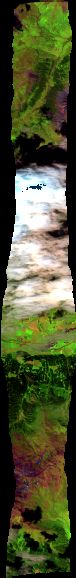

In [22]:
rfl_correct_granule,rfl_correct_qlook,rfl_correct_log = get_output(rfl_corr_job_response.id)
print(rfl_correct_granule)

IPython.display.Image(rfl_correct_qlook)